# 1. Business understanding

Sparkify is a hypothetical music streaming company that offers free and paid subscription plans for their customers. The income streams for the company is either paid ads for the free tier or the monthly subscription fee for the paid tier. The company wishes to predict which customers are likely to churn- either by cancelling their account or downgrading their service from the paid tier to the free tier. 

# 2. Data Understanding

In [1]:
!pip install --upgrade --no-deps seaborn pandas 

Waiting for a Spark session to start...
Spark Initialization Done! ApplicationId = app-20190328164347-0000
KERNEL_ID = 39fc0f9b-dc75-4c1f-bed7-8cc2e56960d7
    100% |################################| 215kB 4.8MB/s eta 0:00:01
    100% |################################| 10.0MB 1.5MB/s eta 0:00:01


In [353]:
# Importing libraries
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import StringType, IntegerType, FloatType
import datetime
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from pyspark.ml import Pipeline
from pyspark.ml.feature import (VectorIndexer,OneHotEncoderEstimator,VectorAssembler,
                                StringIndexer, StringIndexerModel,StandardScaler)
from pyspark.ml.classification import RandomForestClassifier,GBTClassifier,LinearSVC, GBTClassificationModel
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator,Evaluator
from collections import defaultdict
%matplotlib inline

In [3]:
# Create spark session
spark = SparkSession \
    .builder \
    .appName("Sparkify") \
    .getOrCreate()

In [4]:
# The code was removed by Watson Studio for sharing.

Let's start by importing the data and having a look at some of the rows

In [5]:
user_log = spark.read.json(cos.url('medium-sparkify-event-data.json', 'udacitycapstoneproject-donotdelete-pr-f7dzgod30qrwpk'),)
user_log.take(5)

[Row(artist='Martin Orford', auth='Logged In', firstName='Joseph', gender='M', itemInSession=20, lastName='Morales', length=597.55057, level='free', location='Corpus Christi, TX', method='PUT', page='NextSong', registration=1532063507000, sessionId=292, song='Grand Designs', status=200, ts=1538352011000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"', userId='293'),
 Row(artist="John Brown's Body", auth='Logged In', firstName='Sawyer', gender='M', itemInSession=74, lastName='Larson', length=380.21179, level='free', location='Houston-The Woodlands-Sugar Land, TX', method='PUT', page='NextSong', registration=1538069638000, sessionId=97, song='Bulls', status=200, ts=1538352025000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"', userId='98'),
 Row(artist='Afroman', auth='Logged In', firstName='Maverick', gender='M', 

In [6]:
# Calculate the number of rows
nrows = user_log.count()
print('Number of rows: {}'.format(nrows))

Number of rows: 543705


In [7]:
# Calculate the number of columns
ncols = len(user_log.columns)
print('Number of columns: {}'.format(ncols))

Number of columns: 18


In [8]:
# Distinct number of users in dataframe

distinct_number_users = user_log.select('userId').distinct().count()
print('Distinct Number of users: {}'.format(distinct_number_users))

Distinct Number of users: 449


In [9]:
# Investigating the fields and field types 
user_log.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [10]:
# Split the variables into character and numeric for subsequent analysis

num_vars = []
char_vars = []
for var, var_type in user_log.dtypes:
    if var_type == 'string':
        char_vars.append(var)
    else:
        num_vars.append(var)

In [11]:
num_vars

['itemInSession', 'length', 'registration', 'sessionId', 'status', 'ts']

In [12]:
char_vars

['artist',
 'auth',
 'firstName',
 'gender',
 'lastName',
 'level',
 'location',
 'method',
 'page',
 'song',
 'userAgent',
 'userId']

## Summary Statistics

In [13]:
# Summary  statistics for numeric variables

summary_stats = user_log.describe(*num_vars)

In [14]:
summary_stats.toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
itemInSession,543705,107.30629109535502,116.72350849188166,0,1005
length,432877,248.66459278007412,98.41266955052022,0.78322,3024.66567
registration,528005,1.5355234148639531E12,3.0787254929962516E9,1509854193000,1543073874000
sessionId,543705,2040.8143533717732,1434.3389310782668,1,4808
status,543705,210.01829116892432,31.471919021567203,200,404
ts,543705,1.5409645412097434E12,1.4820571449120133E9,1538352011000,1543622466000


In [15]:
eval_char_vars = ['artist',
 'auth',
 'gender',
 'level',
 'method',
 'page',
 'song',
 'userAgent']

In [16]:
for var in eval_char_vars:
    count_var = 'count('+ var + ')'
    (user_log.groupBy(var)
                .agg(F.count('userId').alias('count'))
                .sort(F.desc('count'))).show(truncate=False)

+----------------------+------+
|artist                |count |
+----------------------+------+
|null                  |110828|
|Kings Of Leon         |3497  |
|Coldplay              |3439  |
|Florence + The Machine|2314  |
|Muse                  |2194  |
|Dwight Yoakam         |2187  |
|The Black Keys        |2160  |
|BjÃÂ¶rk              |2150  |
|Justin Bieber         |2096  |
|Jack Johnson          |2049  |
|Radiohead             |1694  |
|Eminem                |1686  |
|Alliance Ethnik       |1654  |
|OneRepublic           |1651  |
|Taylor Swift          |1555  |
|The Killers           |1554  |
|Train                 |1537  |
|Linkin Park           |1487  |
|Evanescence           |1426  |
|John Mayer            |1350  |
+----------------------+------+
only showing top 20 rows

+----------+------+
|auth      |count |
+----------+------+
|Logged In |527906|
|Logged Out|15606 |
|Cancelled |99    |
|Guest     |94    |
+----------+------+

+------+------+
|gender|count |
+------+-----

### Missing values 

Next we can investigate  the missing values patterns

In [17]:
columns_perc_missing = user_log.select(*(F.mean(F.col(column).isNull().cast("int")).alias(column) for column in user_log.columns))

In [18]:
columns_perc_missing.toPandas()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,0.203838,0.0,0.028876,0.028876,0.0,0.028876,0.203838,0.0,0.028876,0.0,0.0,0.028876,0.0,0.203838,0.0,0.0,0.028876,0.0


In [19]:
# Drop unnecessary columns
user_log = user_log.drop(*['firstName','lastName','Artist','song'])

In [20]:
# The ts field is the timestamp for when the action was performed by the user. These are in milliseconds. 
# For all date calculations we therefore need to divide the ts field by a 1000
# We'll create two new fields: date and registration_date. 

user_log = user_log.withColumn('ts', ((F.col('ts')/ 1000.0).cast("timestamp")))
user_log = user_log.withColumn("date", F.to_date(F.col("ts")))
user_log = user_log.withColumn('registration', ((F.col('registration')/ 1000.0).cast("timestamp")))
user_log = user_log.withColumn('registration_date', F.to_date(F.col("registration")))

In [21]:
# Investigate the minimum and maximum dates in the dataframe
user_log.agg(F.min('date'), F.max('date')).show()

+----------+----------+
| min(date)| max(date)|
+----------+----------+
|2018-10-01|2018-12-01|
+----------+----------+



We see that the data comprises of two months' worth of interactions by the users: November and December 2018.

In [22]:
user_log.agg(F.min('registration_date'), F.max('registration_date')).show()

+----------------------+----------------------+
|min(registration_date)|max(registration_date)|
+----------------------+----------------------+
|            2017-11-05|            2018-11-24|
+----------------------+----------------------+



The outcome variable we are interested in predicting is whether a customer churned. In this context it means the customer either downgraded from a paid subscription to a free subscription or the customer closed his/her account altogether. There are also `downgrade` actions. These were investigated and it was established that the customer didn't actually downgrade after this action. It most probably means that the customer visited the `downgrade` page

In [23]:
user_log = user_log.withColumn('Churned', (F.when(F.col("page").isin(['Submit Downgrade','Cancel']) , 1)
                                           .otherwise(0)))

In [24]:
# Create outcome/Target variable 
churn_by_user =user_log.groupBy('userId').agg(F.max('Churned').alias('Churned'))

In [25]:
churn_rate = churn_by_user.agg(F.mean('Churned')).collect()

In [26]:
print('Baseline Churn rate: {0:.2f}'.format(churn_rate[0][0]))

Baseline Churn rate: 0.39


In [27]:
# Investigate the number of customers who churned per day

churn_by_user_date = user_log.groupBy(['userId','date']).agg(F.max('Churned').alias('Churned'))
number_churn_per_day = churn_by_user_date.groupBy('date').agg(F.sum('Churned').alias('Churned'))

In [28]:
number_churn_per_day_pd = number_churn_per_day.toPandas()

In [29]:
number_churn_per_day_pd.head()

,date,Churned
0,2018-11-02,5
1,2018-10-05,7
2,2018-11-01,3
3,2018-10-04,2
4,2018-10-09,4


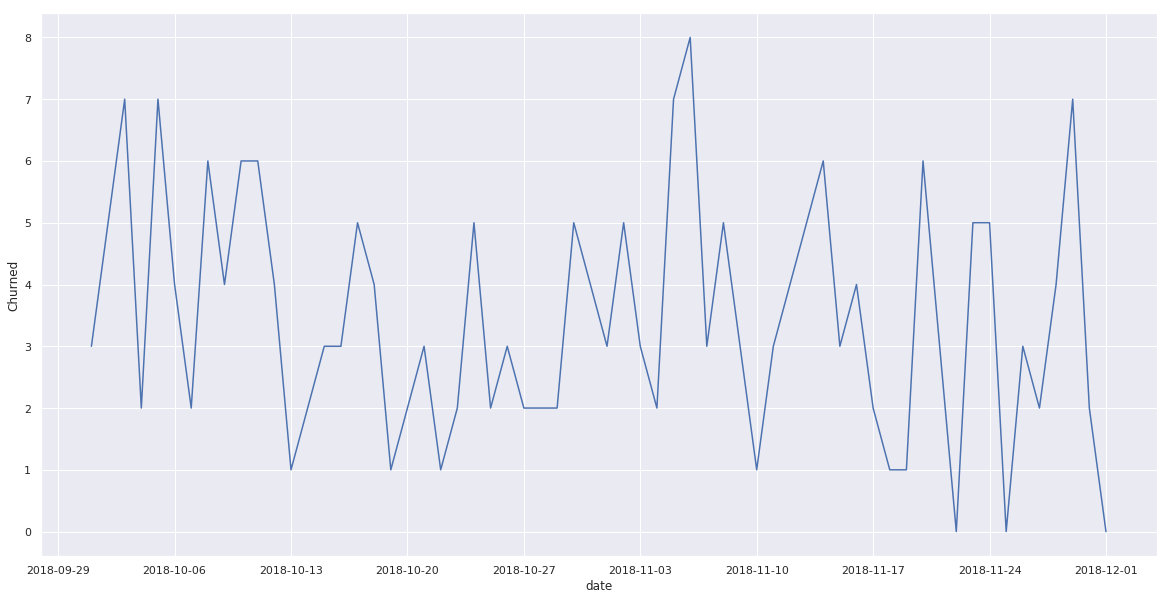

In [30]:
sns.set(style="darkgrid")
plt.figure(figsize=(20,10))
sns.lineplot(x="date", y="Churned",data=number_churn_per_day_pd);

# 3. Data preparation


Next  we need to create some features that can be used in the churn model

In [31]:
# Firstly we are interested in the first time the customer actually churned.
churn_date_per_user = user_log.filter('Churned == 1').groupBy('userId').agg(F.min('date').alias('Churned_date'))

In [32]:
user_log_with_churnind = user_log.join(churn_date_per_user,on='userId', how='left')

In [33]:
user_log_with_churnind.take(1)

[Row(userId='100010', auth='Logged In', gender='F', itemInSession=0, length=226.08934, level='free', location='Bridgeport-Stamford-Norwalk, CT', method='PUT', page='NextSong', registration=datetime.datetime(2018, 9, 27, 2, 45, 40), sessionId=62, status=200, ts=datetime.datetime(2018, 10, 8, 9, 36, 32), userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', date=datetime.date(2018, 10, 8), registration_date=datetime.date(2018, 9, 27), Churned=0, Churned_date=datetime.date(2018, 10, 11))]

In [34]:
# Next we want to create a new field `Ref_date` that either contain the first time the customer actually churned or the last date in the dataframe.
user_log_with_churnind.createTempView('user_log_with_churnind')

In [35]:
user_log_with_churnind = spark.sql('''SELECT *, 
            CASE WHEN Churned_date IS NULL then '2018-12-01'
            ELSE Churned_date END as Ref_date
            FROM user_log_with_churnind
            ''')

In [36]:
#Check results

user_log_with_churnind.groupBy('userId').agg(F.max('Churned'),F.min('ref_date')).show()

+------+------------+-------------+
|userId|max(Churned)|min(ref_date)|
+------+------------+-------------+
|100010|           1|   2018-10-11|
|200002|           1|   2018-10-30|
|   296|           1|   2018-10-10|
|   125|           0|   2018-12-01|
|   124|           1|   2018-11-11|
|    51|           1|   2018-10-16|
|     7|           0|   2018-12-01|
|200037|           1|   2018-10-24|
|   169|           0|   2018-12-01|
|   205|           0|   2018-12-01|
|   272|           0|   2018-12-01|
|    15|           0|   2018-12-01|
|   232|           1|   2018-11-02|
|   234|           1|   2018-11-01|
|   282|           0|   2018-12-01|
|    54|           1|   2018-10-08|
|   155|           0|   2018-12-01|
|200043|           0|   2018-12-01|
|100014|           1|   2018-10-21|
|   132|           1|   2018-10-08|
+------+------------+-------------+
only showing top 20 rows



In [37]:
# We can now create the observation period. This will contain all user action before the end of the reference date
observation_period = user_log_with_churnind.filter('date < ref_date')

In [38]:
# Number of observations in the observation dataset
print('Number of observations in the observation dataset: {}'.format(observation_period.count()))

Number of observations in the observation dataset: 432669


In [39]:
# Calculate the number of months the customer has been a customer
observation_period = observation_period.withColumn('length_relationship', F.datediff(F.col('ref_date'),F.col('registration_date'))/365.25*12)


In [40]:
observation_period.describe('length_relationship').show()

+-------+-------------------+
|summary|length_relationship|
+-------+-------------------+
|  count|             416969|
|   mean|  2.780304365567115|
| stddev|  1.133286058150344|
|    min|                0.0|
|    max| 12.845995893223819|
+-------+-------------------+



This is quite a new base. We see the oldest  customer has only been on book for around 13 months and the youngest less than a month. 

In [41]:
# Get the unique pages/interactions

categories = observation_period.select("page").distinct().rdd.flatMap(lambda x: x).collect()

In [42]:
# Create indicator variables for these interactions
exprs = [F.when(F.col("page") == category, 1).otherwise(0).alias(category)
         for category in categories]

In [43]:
observation_period = observation_period.select('*', *exprs).withColumn('week',F.weekofyear('date'))

In [44]:
observation_period.take(3)

[Row(userId='100010', auth='Logged In', gender='F', itemInSession=0, length=226.08934, level='free', location='Bridgeport-Stamford-Norwalk, CT', method='PUT', page='NextSong', registration=datetime.datetime(2018, 9, 27, 2, 45, 40), sessionId=62, status=200, ts=datetime.datetime(2018, 10, 8, 9, 36, 32), userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', date=datetime.date(2018, 10, 8), registration_date=datetime.date(2018, 9, 27), Churned=0, Churned_date=datetime.date(2018, 10, 11), Ref_date='2018-10-11', length_relationship=0.45995893223819295, Thumbs Down=0, Home=0, Downgrade=0, Roll Advert=0, Logout=0, Save Settings=0, About=0, Submit Registration=0, Settings=0, Login=0, Register=0, Add to Playlist=0, Add Friend=0, NextSong=1, Thumbs Up=0, Help=0, Upgrade=0, Error=0, Submit Upgrade=0, week=41),
 Row(userId='100010', auth='Logged In', gender='F', itemInSession=1, length=285.41342, lev

In [45]:
observation_period.columns

['userId',
 'auth',
 'gender',
 'itemInSession',
 'length',
 'level',
 'location',
 'method',
 'page',
 'registration',
 'sessionId',
 'status',
 'ts',
 'userAgent',
 'date',
 'registration_date',
 'Churned',
 'Churned_date',
 'Ref_date',
 'length_relationship',
 'Thumbs Down',
 'Home',
 'Downgrade',
 'Roll Advert',
 'Logout',
 'Save Settings',
 'About',
 'Submit Registration',
 'Settings',
 'Login',
 'Register',
 'Add to Playlist',
 'Add Friend',
 'NextSong',
 'Thumbs Up',
 'Help',
 'Upgrade',
 'Error',
 'Submit Upgrade',
 'week']

In [46]:
# Calculate the number of interactions per user per week
exprs = [F.sum(cat).alias(cat)  for cat in categories]

In [47]:
total_number_interactions_week = observation_period.groupBy(['userId','week']).agg(*exprs)

In [48]:
total_number_interactions_week.select(F.max('week')).show()

+---------+
|max(week)|
+---------+
|       48|
+---------+



In [49]:
tot_num_interactions_last_week = total_number_interactions_week.filter('week == 48')

In [50]:
total_number_interactions_week.take(3)

[Row(userId='100010', week=41, Thumbs Down=2, Home=2, Downgrade=0, Roll Advert=10, Logout=1, Save Settings=0, About=0, Submit Registration=0, Settings=0, Login=0, Register=0, Add to Playlist=1, Add Friend=1, NextSong=49, Thumbs Up=3, Help=0, Upgrade=0, Error=0, Submit Upgrade=0),
 Row(userId='200002', week=40, Thumbs Down=1, Home=7, Downgrade=0, Roll Advert=6, Logout=4, Save Settings=0, About=0, Submit Registration=0, Settings=0, Login=0, Register=0, Add to Playlist=1, Add Friend=2, NextSong=82, Thumbs Up=4, Help=0, Upgrade=1, Error=0, Submit Upgrade=0),
 Row(userId='200002', week=41, Thumbs Down=1, Home=10, Downgrade=1, Roll Advert=5, Logout=3, Save Settings=0, About=1, Submit Registration=0, Settings=0, Login=0, Register=0, Add to Playlist=3, Add Friend=0, NextSong=123, Thumbs Up=8, Help=1, Upgrade=1, Error=0, Submit Upgrade=1)]

In [51]:
# Calculate the average number of interactions for the user 
exprs = [F.mean(cat).alias('Average number of ' + cat)  for cat in categories]

In [52]:
exprs

[Column<b'avg(Thumbs Down) AS `Average number of Thumbs Down`'>,
 Column<b'avg(Home) AS `Average number of Home`'>,
 Column<b'avg(Downgrade) AS `Average number of Downgrade`'>,
 Column<b'avg(Roll Advert) AS `Average number of Roll Advert`'>,
 Column<b'avg(Logout) AS `Average number of Logout`'>,
 Column<b'avg(Save Settings) AS `Average number of Save Settings`'>,
 Column<b'avg(About) AS `Average number of About`'>,
 Column<b'avg(Submit Registration) AS `Average number of Submit Registration`'>,
 Column<b'avg(Settings) AS `Average number of Settings`'>,
 Column<b'avg(Login) AS `Average number of Login`'>,
 Column<b'avg(Register) AS `Average number of Register`'>,
 Column<b'avg(Add to Playlist) AS `Average number of Add to Playlist`'>,
 Column<b'avg(Add Friend) AS `Average number of Add Friend`'>,
 Column<b'avg(NextSong) AS `Average number of NextSong`'>,
 Column<b'avg(Thumbs Up) AS `Average number of Thumbs Up`'>,
 Column<b'avg(Help) AS `Average number of Help`'>,
 Column<b'avg(Upgrade)

In [53]:
total_avg_interactions = total_number_interactions_week.groupBy('userId').agg(*exprs)

In [54]:
total_avg_interactions.take(3)

[Row(userId='100010', Average number of Thumbs Down=2.0, Average number of Home=2.0, Average number of Downgrade=0.0, Average number of Roll Advert=10.0, Average number of Logout=1.0, Average number of Save Settings=0.0, Average number of About=0.0, Average number of Submit Registration=0.0, Average number of Settings=0.0, Average number of Login=0.0, Average number of Register=0.0, Average number of Add to Playlist=1.0, Average number of Add Friend=1.0, Average number of NextSong=49.0, Average number of Thumbs Up=3.0, Average number of Help=0.0, Average number of Upgrade=0.0, Average number of Error=0.0, Average number of Submit Upgrade=0.0),
 Row(userId='200002', Average number of Thumbs Down=0.6666666666666666, Average number of Home=7.333333333333333, Average number of Downgrade=0.6666666666666666, Average number of Roll Advert=3.6666666666666665, Average number of Logout=3.6666666666666665, Average number of Save Settings=0.0, Average number of About=0.3333333333333333, Average nu

In [55]:
# Create indicator variables for the last 7 days of the observation period
observation_period = (observation_period
                      .withColumn('last_7_days', F.when(F.col('date') >= F.date_sub(F.col('ref_date'),7),1)
                      .otherwise(0)))

In [56]:
observation_period.take(3)

[Row(userId='100010', auth='Logged In', gender='F', itemInSession=0, length=226.08934, level='free', location='Bridgeport-Stamford-Norwalk, CT', method='PUT', page='NextSong', registration=datetime.datetime(2018, 9, 27, 2, 45, 40), sessionId=62, status=200, ts=datetime.datetime(2018, 10, 8, 9, 36, 32), userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', date=datetime.date(2018, 10, 8), registration_date=datetime.date(2018, 9, 27), Churned=0, Churned_date=datetime.date(2018, 10, 11), Ref_date='2018-10-11', length_relationship=0.45995893223819295, Thumbs Down=0, Home=0, Downgrade=0, Roll Advert=0, Logout=0, Save Settings=0, About=0, Submit Registration=0, Settings=0, Login=0, Register=0, Add to Playlist=0, Add Friend=0, NextSong=1, Thumbs Up=0, Help=0, Upgrade=0, Error=0, Submit Upgrade=0, week=41, last_7_days=1),
 Row(userId='100010', auth='Logged In', gender='F', itemInSession=1, length

In [57]:
# Calculate the number of interactions per user for the last 7 days
exprs = [F.sum(cat).alias('Number ' + cat + ' last 7 days')  for cat in categories]

In [58]:
total_number_interactions_last7days = observation_period.where('last_7_days==1').groupBy('userId').agg(*exprs)

In [59]:
total_number_interactions_last7days.count()

311

In [60]:
# Creating a dataframe containing the demographics of the customer

demographics = observation_period.select(['userId', 'gender','location','length_relationship']).distinct()

In [61]:
demographics.count()

436

In [62]:
demographics.show(truncate=False,vertical=True)

-RECORD 0----------------------------------------------------
 userId              | 100010                                
 gender              | F                                     
 location            | Bridgeport-Stamford-Norwalk, CT       
 length_relationship | 0.45995893223819295                   
-RECORD 1----------------------------------------------------
 userId              | 200002                                
 gender              | M                                     
 location            | Chicago-Naperville-Elgin, IL-IN-WI    
 length_relationship | 1.7741273100616017                    
-RECORD 2----------------------------------------------------
 userId              | 296                                   
 gender              | F                                     
 location            | Allentown-Bethlehem-Easton, PA-NJ     
 length_relationship | 0.8542094455852156                    
-RECORD 3----------------------------------------------------
 userId 

In [63]:
# Create a variable containing the Sate the customer resides in
demographics = demographics.withColumn('State', F.split(F.split(F.col('location'),',')[1],'-')[0])

In [64]:
demographics.show(truncate=False)

+------+------+-------------------------------------+-------------------+-----+
|userId|gender|location                             |length_relationship|State|
+------+------+-------------------------------------+-------------------+-----+
|100010|F     |Bridgeport-Stamford-Norwalk, CT      |0.45995893223819295| CT  |
|200002|M     |Chicago-Naperville-Elgin, IL-IN-WI   |1.7741273100616017 | IL  |
|296   |F     |Allentown-Bethlehem-Easton, PA-NJ    |0.8542094455852156 | PA  |
|125   |M     |Corpus Christi, TX                   |4.008213552361396  | TX  |
|124   |F     |Vineland-Bridgeton, NJ               |3.6796714579055436 | NJ  |
|51    |M     |Lexington-Fayette, KY                |0.6242299794661191 | KY  |
|7     |M     |Seattle-Tacoma-Bellevue, WA          |2.661190965092403  | WA  |
|200037|M     |Columbus, GA-AL                      |1.4127310061601643 | GA  |
|169   |M     |Lafayette-West Lafayette, IN         |2.628336755646817  | IN  |
|205   |F     |Ottawa-Peru, IL          

In [65]:
demographics.groupBy('State').count().show()

+-----+-----+
|State|count|
+-----+-----+
|   ME|    1|
|   WA|   10|
|   AL|    9|
|   NM|    3|
|   MI|   10|
|   HI|    1|
|   VT|    1|
|   MO|    8|
|   NE|    2|
| null|    1|
|   RI|    5|
|   NH|    3|
|   AK|    2|
|   AR|    2|
|   AZ|   10|
|   WV|    2|
|   TN|    8|
|   MA|    8|
|   NY|   36|
|   MD|    5|
+-----+-----+
only showing top 20 rows



In [66]:
churn_by_user.count()

449

In [67]:
# Join all the data together

combined_df = (demographics.join(tot_num_interactions_last_week,on='userId', how='left')
               .join(total_avg_interactions,on='userId', how='left')
               .join(churn_by_user,on='userId', how='left')
              )


In [68]:
combined_df.columns

['userId',
 'gender',
 'location',
 'length_relationship',
 'State',
 'week',
 'Thumbs Down',
 'Home',
 'Downgrade',
 'Roll Advert',
 'Logout',
 'Save Settings',
 'About',
 'Submit Registration',
 'Settings',
 'Login',
 'Register',
 'Add to Playlist',
 'Add Friend',
 'NextSong',
 'Thumbs Up',
 'Help',
 'Upgrade',
 'Error',
 'Submit Upgrade',
 'Average number of Thumbs Down',
 'Average number of Home',
 'Average number of Downgrade',
 'Average number of Roll Advert',
 'Average number of Logout',
 'Average number of Save Settings',
 'Average number of About',
 'Average number of Submit Registration',
 'Average number of Settings',
 'Average number of Login',
 'Average number of Register',
 'Average number of Add to Playlist',
 'Average number of Add Friend',
 'Average number of NextSong',
 'Average number of Thumbs Up',
 'Average number of Help',
 'Average number of Upgrade',
 'Average number of Error',
 'Average number of Submit Upgrade',
 'Churned']

In [69]:
# Drop the variables that might either bias the model or not be of much use
combined_df = combined_df.drop(*['Average number of Cancel','Average number of Submit Downgrade',
                                 'Average number of Cancellation Confirmation',
                                'Cancel','Submit Downgrade','Cancellation Confirmation','week','location'])

In [70]:
categories

['Thumbs Down',
 'Home',
 'Downgrade',
 'Roll Advert',
 'Logout',
 'Save Settings',
 'About',
 'Submit Registration',
 'Settings',
 'Login',
 'Register',
 'Add to Playlist',
 'Add Friend',
 'NextSong',
 'Thumbs Up',
 'Help',
 'Upgrade',
 'Error',
 'Submit Upgrade']

In [71]:
# Create some ratio variables between the number of interactions in the last week over the average number of interactions.

base_vars = [cat for cat in categories if cat not in ['Cancel','Submit Downgrade','Cancellation Confirmation']]
compare_vars = ['Average number of ' + cat for cat in base_vars]

In [72]:
exprs = [(F.col(var)/F.col(var_i)).alias(var + ' ratio')  for var,var_i in zip(base_vars,compare_vars)]

In [73]:
exprs

[Column<b'(Thumbs Down / Average number of Thumbs Down) AS `Thumbs Down ratio`'>,
 Column<b'(Home / Average number of Home) AS `Home ratio`'>,
 Column<b'(Downgrade / Average number of Downgrade) AS `Downgrade ratio`'>,
 Column<b'(Roll Advert / Average number of Roll Advert) AS `Roll Advert ratio`'>,
 Column<b'(Logout / Average number of Logout) AS `Logout ratio`'>,
 Column<b'(Save Settings / Average number of Save Settings) AS `Save Settings ratio`'>,
 Column<b'(About / Average number of About) AS `About ratio`'>,
 Column<b'(Submit Registration / Average number of Submit Registration) AS `Submit Registration ratio`'>,
 Column<b'(Settings / Average number of Settings) AS `Settings ratio`'>,
 Column<b'(Login / Average number of Login) AS `Login ratio`'>,
 Column<b'(Register / Average number of Register) AS `Register ratio`'>,
 Column<b'(Add to Playlist / Average number of Add to Playlist) AS `Add to Playlist ratio`'>,
 Column<b'(Add Friend / Average number of Add Friend) AS `Add Friend r

In [74]:
combined_df = combined_df.select('*', *exprs)
    

In [75]:
combined_df.columns

['userId',
 'gender',
 'length_relationship',
 'State',
 'Thumbs Down',
 'Home',
 'Downgrade',
 'Roll Advert',
 'Logout',
 'Save Settings',
 'About',
 'Submit Registration',
 'Settings',
 'Login',
 'Register',
 'Add to Playlist',
 'Add Friend',
 'NextSong',
 'Thumbs Up',
 'Help',
 'Upgrade',
 'Error',
 'Submit Upgrade',
 'Average number of Thumbs Down',
 'Average number of Home',
 'Average number of Downgrade',
 'Average number of Roll Advert',
 'Average number of Logout',
 'Average number of Save Settings',
 'Average number of About',
 'Average number of Submit Registration',
 'Average number of Settings',
 'Average number of Login',
 'Average number of Register',
 'Average number of Add to Playlist',
 'Average number of Add Friend',
 'Average number of NextSong',
 'Average number of Thumbs Up',
 'Average number of Help',
 'Average number of Upgrade',
 'Average number of Error',
 'Average number of Submit Upgrade',
 'Churned',
 'Thumbs Down ratio',
 'Home ratio',
 'Downgrade ratio',
 

In [ ]:
combined_df.head()

In [76]:
check_results = combined_df.describe().toPandas()

In [129]:
check_results

,summary,userId,gender,length_relationship,State,Thumbs Down,Home,Downgrade,Roll Advert,Logout,...,Login ratio,Register ratio,Add to Playlist ratio,Add Friend ratio,NextSong ratio,Thumbs Up ratio,Help ratio,Upgrade ratio,Error ratio,Submit Upgrade ratio
0,count,436,435,435,435,161,161,161,161,161,...,1,1,156,155,160,159,142,118,104,87
1,mean,67235.53793103449,None,2.754693289905355,None,1.4782608695652173,10.24223602484472,1.2732919254658386,1.3788819875776397,1.84472049689441,...,0.700715355182166,0.0,0.9805789586132804,0.908279224981641,0.9835824461727449,0.9881718513022186,0.8120054229485245,0.305945043656908,1.0636275183150183,0.7816091954022989
2,stddev,106418.95361099576,None,1.3191690174948518,None,2.0587828823170593,52.57587093875806,1.854007745533145,3.0942367786315286,2.1981782406437724,...,NaN,NaN,0.9889485269453878,1.1633187524783384,0.8431873305213918,0.9019829890068595,1.4544485670417662,0.9819266952669651,2.2526827310957622,2.3048245020024276
3,min,,F,0.0,AK,0,0,0,0,0,...,0.700715355182166,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,max,99,M,12.845995893223819,WV,14,669,7,19,13,...,0.700715355182166,0.0,5.5,7.0,4.643063583815029,4.509090909090909,9.0,7.0,9.0,9.0


In [78]:
columns_perc_missing = combined_df.select(*(F.mean(F.col(column).isNull().cast("int")).alias(column) for column in combined_df.columns))
columns_perc_missing.toPandas()

,userId,gender,length_relationship,State,Thumbs Down,Home,Downgrade,Roll Advert,Logout,Save Settings,...,Login ratio,Register ratio,Add to Playlist ratio,Add Friend ratio,NextSong ratio,Thumbs Up ratio,Help ratio,Upgrade ratio,Error ratio,Submit Upgrade ratio
0,0.0,0.002294,0.002294,0.002294,0.630734,0.630734,0.630734,0.630734,0.630734,0.630734,...,0.997706,0.997706,0.642202,0.644495,0.633028,0.635321,0.674312,0.729358,0.761468,0.800459


Lastly we need to impute the missing values. The following strategy would be used:
* For the categorical variables, we will impute the value 'Missing''
* For length of relationship, we will impute the value 999
* For the interaction variables and ratio variables, we'll impute the value 0. This is fine in this instance since if the interaction is missing, it means there were 0 interactions

In [79]:
interaction_vars = combined_df.columns[4:23] + combined_df.columns[-19:]

In [80]:
interaction_vars

['Thumbs Down',
 'Home',
 'Downgrade',
 'Roll Advert',
 'Logout',
 'Save Settings',
 'About',
 'Submit Registration',
 'Settings',
 'Login',
 'Register',
 'Add to Playlist',
 'Add Friend',
 'NextSong',
 'Thumbs Up',
 'Help',
 'Upgrade',
 'Error',
 'Submit Upgrade',
 'Thumbs Down ratio',
 'Home ratio',
 'Downgrade ratio',
 'Roll Advert ratio',
 'Logout ratio',
 'Save Settings ratio',
 'About ratio',
 'Submit Registration ratio',
 'Settings ratio',
 'Login ratio',
 'Register ratio',
 'Add to Playlist ratio',
 'Add Friend ratio',
 'NextSong ratio',
 'Thumbs Up ratio',
 'Help ratio',
 'Upgrade ratio',
 'Error ratio',
 'Submit Upgrade ratio']

In [81]:
combined_df = combined_df.na.fill(value='Missing',subset=['gender','State'])
combined_df = combined_df.na.fill(value=999,subset=['length_relationship'])
combined_df = combined_df.na.fill(value=0,subset=interaction_vars)

In [82]:
columns_perc_missing = combined_df.select(*(F.mean(F.col(column).isNull().cast("int")).alias(column) for column in combined_df.columns))
columns_perc_missing.toPandas()

,userId,gender,length_relationship,State,Thumbs Down,Home,Downgrade,Roll Advert,Logout,Save Settings,...,Login ratio,Register ratio,Add to Playlist ratio,Add Friend ratio,NextSong ratio,Thumbs Up ratio,Help ratio,Upgrade ratio,Error ratio,Submit Upgrade ratio
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Some further exploratory data analysis

In [132]:
combined_df_pd = combined_df.toPandas()

In [306]:
combined_df_pd.tail()

,userId,gender,length_relationship,State,Thumbs Down,Home,Downgrade,Roll Advert,Logout,Save Settings,...,Login ratio,Register ratio,Add to Playlist ratio,Add Friend ratio,NextSong ratio,Thumbs Up ratio,Help ratio,Upgrade ratio,Error ratio,Submit Upgrade ratio
431,216,F,3.745380,TX,0,1,0,0,1,0,...,0.0,0.0,0.000000,0.545455,0.110895,0.126761,0.0,0.0,0.0,0.0
432,119,F,6.406571,NC,0,4,0,1,1,0,...,0.0,0.0,1.176471,0.666667,0.450909,0.666667,0.0,0.0,0.0,0.0
433,100001,F,1.478439,FL,0,0,0,0,0,0,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
434,200049,M,4.369610,MI,0,0,0,0,0,0,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
435,300029,M,2.661191,NY,0,0,0,0,0,0,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0


In [138]:
# Summary statistics
combined_df_pd[interaction_vars+ ['Churned']].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Thumbs Down,436.0,0.545872,1.438456,0.0,0.0,0.0,0.000000,14.000000
Home,436.0,3.782110,32.267855,0.0,0.0,0.0,2.000000,669.000000
Downgrade,436.0,0.470183,1.281713,0.0,0.0,0.0,0.000000,7.000000
Roll Advert,436.0,0.509174,1.991339,0.0,0.0,0.0,0.000000,19.000000
Logout,436.0,0.681193,1.603649,0.0,0.0,0.0,0.250000,13.000000
Save Settings,436.0,0.100917,0.399884,0.0,0.0,0.0,0.000000,4.000000
About,436.0,0.284404,3.561846,0.0,0.0,0.0,0.000000,74.000000
Submit Registration,436.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000
Settings,436.0,0.330275,1.024348,0.0,0.0,0.0,0.000000,12.000000
Login,436.0,1.073394,22.413135,0.0,0.0,0.0,0.000000,468.000000


In [308]:
combined_df_pd[interaction_vars].skew()

Thumbs Down                   4.237380
Home                         20.239321
Downgrade                     3.215531
Roll Advert                   5.599951
Logout                        3.385167
Save Settings                 5.146330
About                        20.476173
Submit Registration           0.000000
Settings                      5.620948
Login                        20.880613
Register                      0.000000
Add to Playlist               2.864264
Add Friend                    3.777355
NextSong                      2.817272
Thumbs Up                     2.705557
Help                         13.850146
Upgrade                       8.363696
Error                         4.436890
Submit Upgrade                6.395679
Thumbs Down ratio             3.327810
Home ratio                    2.439302
Downgrade ratio               4.454412
Roll Advert ratio             6.833617
Logout ratio                  2.501605
Save Settings ratio           4.122987
About ratio              

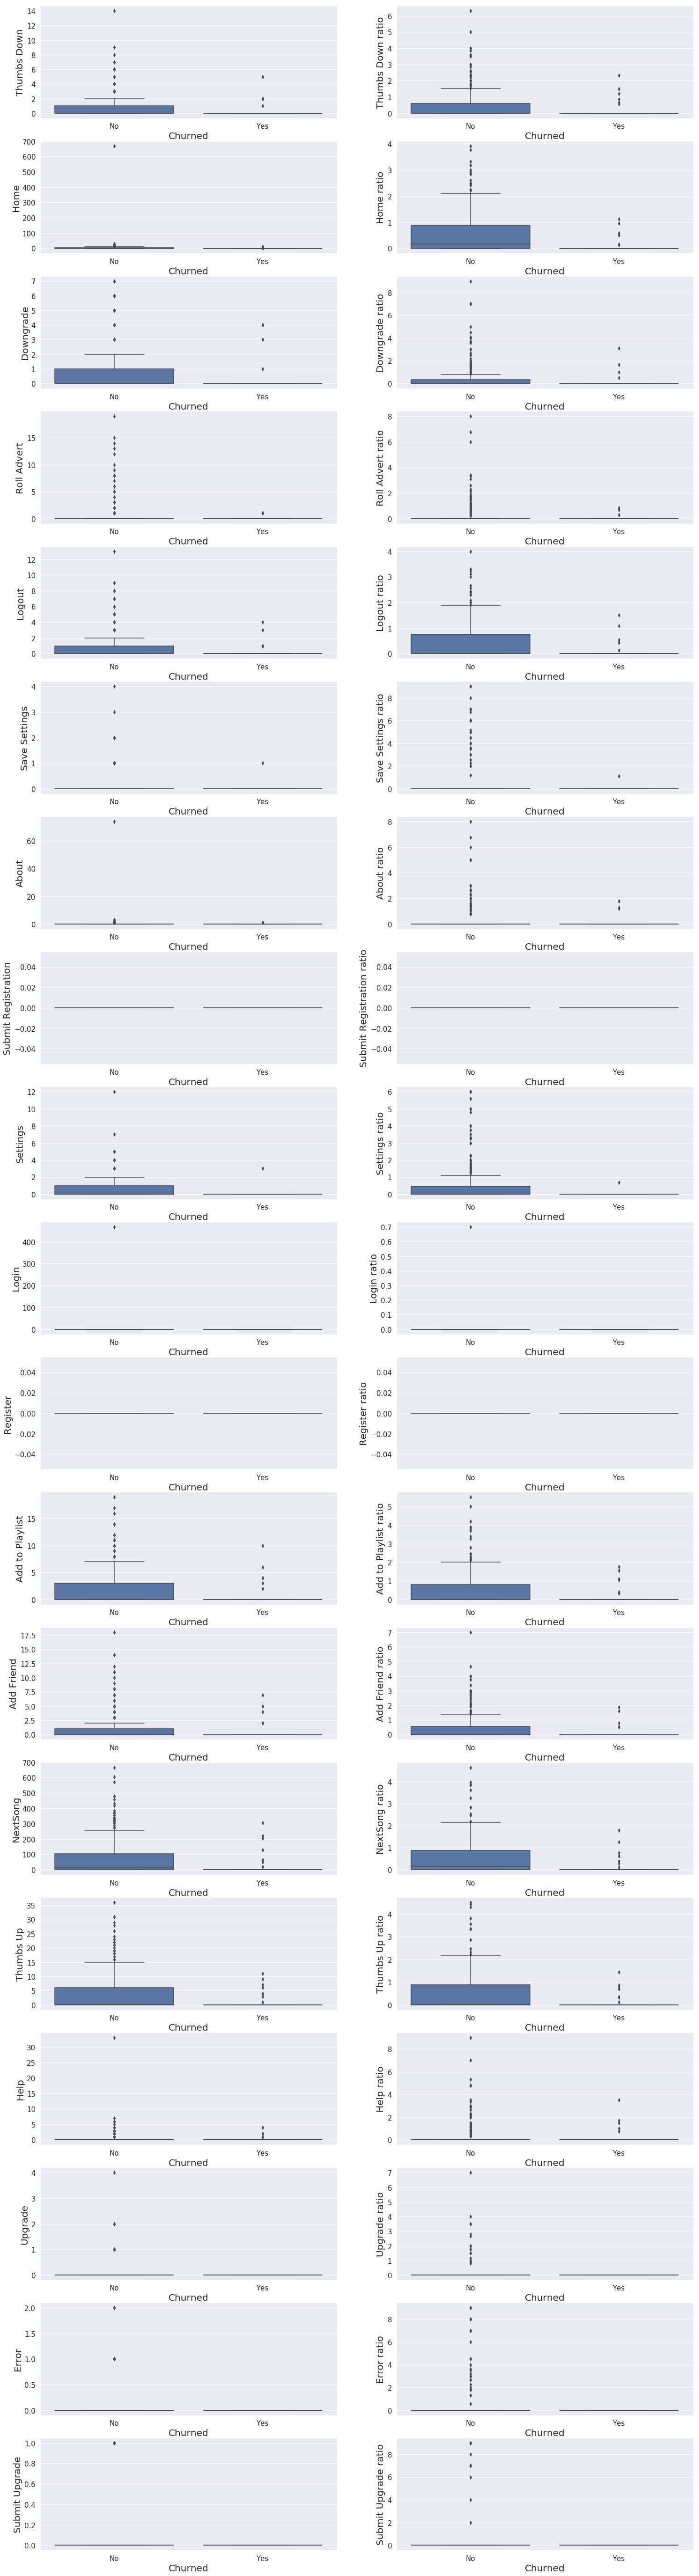

In [84]:
# Box plots of interaction variables vs churn
num_rows = math.ceil(len(interaction_vars)/2)
fig, ax = plt.subplots(num_rows, 2, figsize = (25,100))

feat_num = 0

for col in range(2):
    for row in range(num_rows):
        
        sns.boxplot(x="Churned", y=interaction_vars[feat_num], data=combined_df_pd , palette="deep", ax=ax[row,col]);
        ax[row,col].set_xlabel("Churned", fontsize=20)
        ax[row,col].set_ylabel(interaction_vars[feat_num], fontsize=20)
        ax[row,col].xaxis.set_tick_params(labelsize=15)
        ax[row,col].yaxis.set_tick_params(labelsize=15)
        ax[row,col].xaxis.set_ticklabels(['No','Yes'])

        feat_num += 1

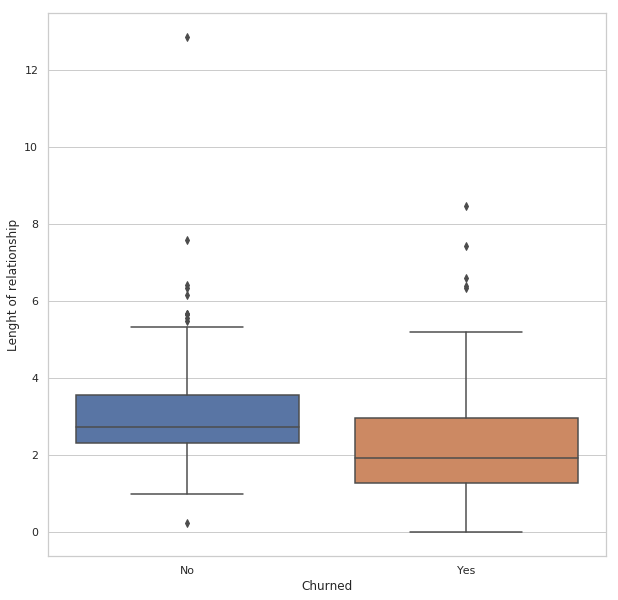

In [157]:
fig, ax = plt.subplots(figsize = (10,10))
sns.boxplot(x="Churned", y='length_relationship', data=combined_df_pd[combined_df_pd['length_relationship'] < 999], palette="deep",ax=ax);
ax.set_xticklabels(['No','Yes']);
ax.set_ylabel('Lenght of relationship');

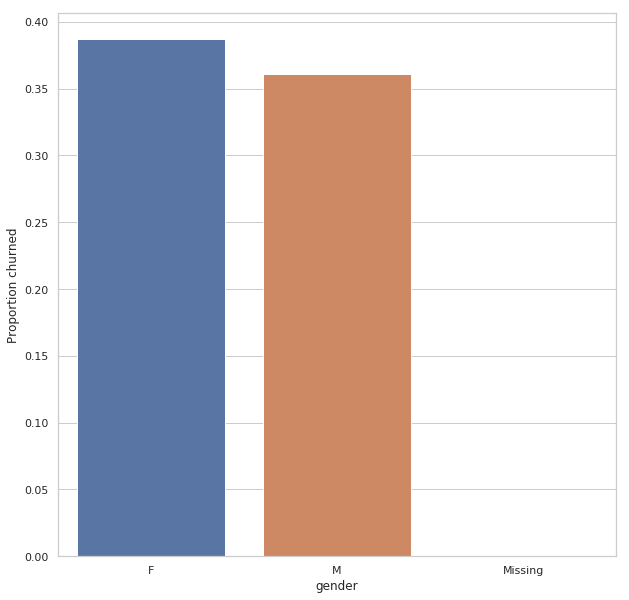

In [158]:
fig, ax = plt.subplots(figsize = (10,10))
sns.barplot(y="Churned",x='gender', data=combined_df_pd , ci= None, palette="deep",ax=ax);
plt.ylabel('Proportion churned');

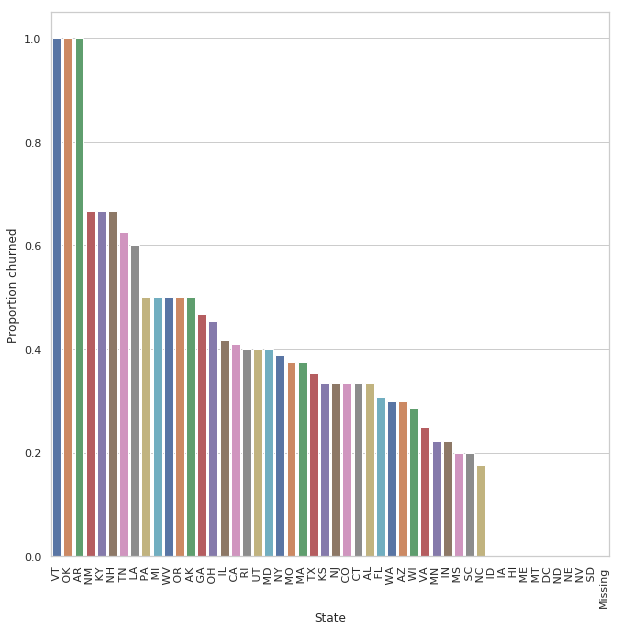

In [168]:
churned_by_state = combined_df_pd.groupby(by= 'State')["Churned"].mean().sort_values(ascending=False)

fig, ax = plt.subplots(figsize = (10,10))
sns.barplot(y=churned_by_state.values,x=churned_by_state.index, ci= None, palette="deep",ax=ax);
ax.set_ylabel('Proportion churned');
plt.xticks(rotation=90);

# 4. Modelling 

In [85]:
# Splitting dataset into train and test sets
combined_df.cache()
train, test = combined_df.randomSplit([0.8,0.2],seed=8989)

In [86]:
# Churn rate for training and test datasets

churn_train = train.select(F.mean('Churned')).collect()[0][0]
churn_test = test.select(F.mean('Churned')).collect()[0][0]
print('Churn rate for training dataset: {0:.2f}'.format(churn_train))
print('Churn rate for test dataset: {0:.2f}'.format(churn_test))

Churn rate for training dataset: 0.38
Churn rate for test dataset: 0.33


In [87]:
feature_columns = train.columns

In [88]:
feature_columns = ['gender_ohe',
 'length_relationship',
 'state_ohe',
 'Thumbs Down',
 'Home',
 'Downgrade',
 'Roll Advert',
 'Logout',
 'Save Settings',
 'About',
 'Submit Registration',
 'Settings',
 'Login',
 'Register',
 'Add to Playlist',
 'Add Friend',
 'NextSong',
 'Thumbs Up',
 'Help',
 'Upgrade',
 'Error',
 'Submit Upgrade',
 'Thumbs Down ratio',
 'Home ratio',
 'Downgrade ratio',
 'Roll Advert ratio',
 'Logout ratio',
 'Save Settings ratio',
 'About ratio',
 'Submit Registration ratio',
 'Settings ratio',
 'Login ratio',
 'Register ratio',
 'Add to Playlist ratio',
 'Add Friend ratio',
 'NextSong ratio',
 'Thumbs Up ratio',
 'Help ratio',
 'Upgrade ratio',
 'Error ratio',
 'Submit Upgrade ratio'] 

### Random forest

In [89]:
# Creating pipeline

gender_indexer = StringIndexer(inputCol='gender', outputCol='gender_index',handleInvalid='keep')
state_indexer = StringIndexer(inputCol='State', outputCol='state_index',handleInvalid='keep')
ohe_gender = OneHotEncoderEstimator(inputCols=['gender_index'],outputCols=['gender_ohe'],dropLast=False)  
ohe_state = OneHotEncoderEstimator(inputCols=['state_index'],outputCols=['state_ohe'] ,dropLast=False)  
vectorizer = VectorAssembler(inputCols=feature_columns,outputCol='features' )
rf_model = RandomForestClassifier(featuresCol='features', labelCol='Churned',seed=4566) #for reproducibility

In [90]:
pipeline = Pipeline(stages=[gender_indexer,state_indexer,ohe_gender,ohe_state,vectorizer,rf_model])

In [91]:
# Fitting pipeline
rf_fitted = pipeline.fit(train)

In [92]:
results = rf_fitted.transform(test)

In [93]:
eval_roc = BinaryClassificationEvaluator(labelCol='Churned',metricName= 'areaUnderPR')

In [94]:
def evaluation_metrics(model_obj,df,beta):
    
    '''
    
    Returns the evaluation metrics (precision, recall,accuracy and F score) for a fitted model object
    
    Arguments:
    
    model_ob: A Spark model object
    df: The dataframe that needs to be avaluated
    beta: float. Weighting for F score
    
    
    Output:
    
    recall: float. The recall of the model 
    precision: float. The precision of the model
    F_score: float. The F score of the model
    accuracy: float. The accuracy of the model  
    
    '''
    
    results = model_obj.transform(df).select('Churned','prediction')

    
    TP = results.filter('Churned == 1 and prediction == 1').count()
    FN = results.filter('Churned == 1 and prediction == 0').count()
    FP = results.filter('Churned == 0 and prediction == 1').count()
    TN = results.filter('Churned == 0 and prediction == 0').count()
    
    recall = TP/ (TP+FN)
    precision = TP / (TP + FP)
    F_score = (1 + beta**2)* (precision*recall)/ (beta**2 * precision + recall)
    accuracy = (TP + TN)/(TP + TN + FN + FP)
    
    return recall, precision, F_score, accuracy
    
    
    

In [95]:
recall, precision, F_score, accuracy = evaluation_metrics(rf_fitted,test,0.5)

In [96]:
print('Area under PR curve: {0:.2f}'.format(eval_roc.evaluate(results)))
print('Accuracy: {0:.2f}'.format(accuracy))
print('Precision: {0:.2f}'.format(precision))
print('Recall: {0:.2f}'.format(recall))
print('F statistic: {0:.2f}'.format(F_score))
        

Area under PR curve: 0.90
Accuracy: 0.79
Precision: 0.62
Recall: 0.90
F statistic: 0.66


In [97]:
results.crosstab('Churned','prediction').show()

+------------------+---+---+
|Churned_prediction|0.0|1.0|
+------------------+---+---+
|                 1|  3| 26|
|                 0| 44| 16|
+------------------+---+---+



For the random forest model we see that it was able to predict 90% of all customers who churned correctly (Recall). Of those who were predicted likely to churn, 62% indeed churned (Precision). We'll make use of the F-score with $\beta = 0.5$ to evaluate our models, since it places more weight on precision 

### Gradient boosting tree

In [98]:
gbt_model = GBTClassifier(featuresCol='features', labelCol='Churned',
                          maxDepth=3,subsamplingRate=0.5,minInstancesPerNode=10,seed=4566)

In [99]:
pipeline2 = Pipeline(stages=[gender_indexer,state_indexer,ohe_gender,ohe_state,vectorizer,gbt_model])

In [100]:
# Fitting pipeline
gbt_fitted = pipeline2.fit(train)

In [101]:
results = gbt_fitted.transform(test)

In [102]:
recall, precision, F_score, accuracy = evaluation_metrics(gbt_fitted,test,0.5)

In [103]:
print('Area under PR curve: {0:.2f}'.format(eval_roc.evaluate(results)))
print('Accuracy: {0:.2f}'.format(accuracy))
print('Precision: {0:.2f}'.format(precision))
print('Recall: {0:.2f}'.format(recall))
print('F statistic: {0:.2f}'.format(F_score))
        

Area under PR curve: 0.90
Accuracy: 0.83
Precision: 0.72
Recall: 0.79
F statistic: 0.73


In [104]:
results.crosstab('Churned','prediction').show()

+------------------+---+---+
|Churned_prediction|0.0|1.0|
+------------------+---+---+
|                 1|  6| 23|
|                 0| 51|  9|
+------------------+---+---+



### Support vector machine

In [105]:
SVC_model = LinearSVC(labelCol='Churned',standardization=True,regParam=0.01)

In [106]:
pipeline3 = Pipeline(stages=[gender_indexer,state_indexer,ohe_gender,ohe_state,vectorizer,SVC_model])

In [107]:
# Fitting pipeline
svc_fitted = pipeline3.fit(train)

In [108]:
results = svc_fitted.transform(test)

In [109]:
recall, precision, F_score, accuracy = evaluation_metrics(svc_fitted,test,0.5)

In [110]:
print('Area under PR curve: {0:.2f}'.format(eval_roc.evaluate(results)))
print('Accuracy: {0:.2f}'.format(accuracy))
print('Precision: {0:.2f}'.format(precision))
print('Recall: {0:.2f}'.format(recall))
print('F statistic: {0:.2f}'.format(F_score))

Area under PR curve: 0.73
Accuracy: 0.73
Precision: 0.56
Recall: 0.76
F statistic: 0.59


In [111]:
results.crosstab('Churned','prediction').show()

+------------------+---+---+
|Churned_prediction|0.0|1.0|
+------------------+---+---+
|                 1|  7| 22|
|                 0| 43| 17|
+------------------+---+---+



We see that the Gradient Boosting Classifier outperforms the Random Forest and Support vector machine based on the F statistic, so next we'll tune the hyperparameters for the GBC.

In [112]:
 param_grid = (ParamGridBuilder()
               .addGrid(gbt_model.maxDepth, [2, 3, 5]) 
               .addGrid(gbt_model.minInstancesPerNode, [1,10,20]) 
               .build())

Since Spark doesn't have a built-in evaluator that returns the f-score, we need to create our own. We'll use the following [solution](https://stackoverflow.com/questions/51404344/custom-evaluator-in-pyspark)

In [113]:
class F_evaluator(Evaluator):
    
    '''
    F score evaluator for binary classification.

    Arguments:
        predictionCol: string. Name of the prediction column. Must be of type double (binary 0/1)
        labelCol: string. Name of the outcome/target column
        beta: Integer/float. Weighting for F score
    
    Output:
        None
    
    '''



    def __init__(self, predictionCol="prediction", labelCol='label',beta=2):
        
        self.predictionCol = predictionCol
        self.labelCol = labelCol
        self.beta = beta

    def _evaluate(self, dataset):
        """
        
        """
        
        
        TP = dataset.filter((dataset[self.labelCol] == 1) & (dataset[self.predictionCol] == 1)).count()
        FN = dataset.filter((dataset[self.labelCol] == 1) & (dataset[self.predictionCol] == 0)).count()
        FP = dataset.filter((dataset[self.labelCol] == 0) & (dataset[self.predictionCol] == 1)).count()
        TN = dataset.filter((dataset[self.labelCol] == 0) & (dataset[self.predictionCol] == 0)).count()
    
        recall = TP/ (TP+FN)
        precision = TP / (TP + FP)
        F_score = (1 + self.beta **2)* (precision*recall)/ (self.beta **2 * precision + recall)
         
        return F_score

    def isLargerBetter(self):
        return True

In [114]:
evaluator= F_evaluator(labelCol='Churned',beta=0.5)

In [115]:
gridsearch = CrossValidator(estimator=pipeline2,estimatorParamMaps=param_grid,numFolds=3,evaluator=evaluator,parallelism = 10)

In [116]:
cvmodel = gridsearch.fit(train)

Next we can plot the average F score for each of the hyperparameters we searched over

In [262]:
gridsearch_metrics = defaultdict(list)
metric_i = 0
for depth in [2, 3, 5]:
    for instances in [1,10,20]:
        
        gridsearch_metrics['maxDepth'].append(depth)
        gridsearch_metrics['minInstancesPerNode'].append(instances)
        gridsearch_metrics['metric'].append(cvmodel.avgMetrics[metric_i])
        
        metric_i+=1

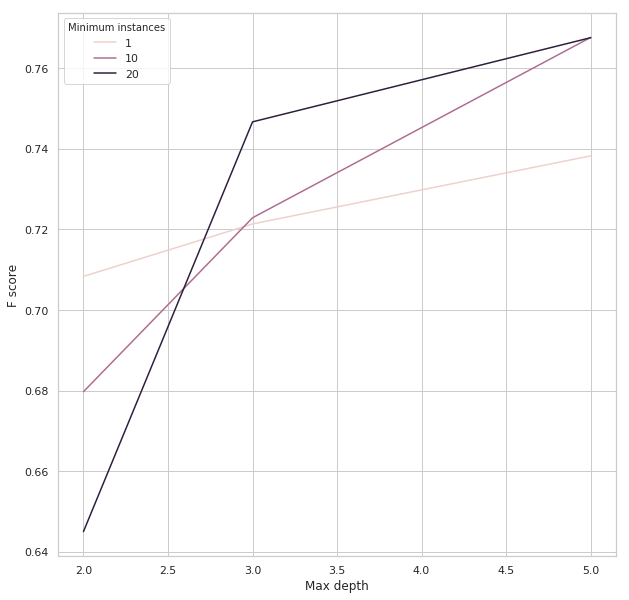

In [293]:
fig, ax = plt.subplots(figsize = (10,10))
g= sns.lineplot(y=gridsearch_metrics['metric'],x=gridsearch_metrics['maxDepth'],
                hue=gridsearch_metrics['minInstancesPerNode'], ax=ax,legend="full")
ax.set_ylabel('F score');
ax.set_xlabel('Max depth');
g.legend(title='Minimum instances');


We see that a MaxDepth of 3 and minInstancesPerNode of 20 gives us the highest F score. Let's save this model

In [117]:
best_model = cvmodel.bestModel

Let's see some of the predictions

In [310]:
predictions = best_model.transform(test)

In [361]:
# Write a function to extract the last value (probability to churn) from the probability vector
secondelement= F.udf(lambda v:float(v[1]),FloatType())

In [360]:
predictions.select(['Churned',secondelement(F.col('probability')).alias('Probability_churn'),'prediction']).show(truncate=False)

+-------+-----------------+----------+
|Churned|Probability_churn|prediction|
+-------+-----------------+----------+
|0      |0.0377655        |0.0       |
|0      |0.26527345       |0.0       |
|0      |0.41152078       |0.0       |
|1      |0.40667504       |0.0       |
|1      |0.94338864       |1.0       |
|0      |0.26527345       |0.0       |
|0      |0.06878584       |0.0       |
|0      |0.063121885      |0.0       |
|1      |0.26527345       |0.0       |
|0      |0.077844486      |0.0       |
|1      |0.90272653       |1.0       |
|0      |0.055031642      |0.0       |
|0      |0.6153404        |1.0       |
|1      |0.94338864       |1.0       |
|0      |0.08013066       |0.0       |
|1      |0.90131664       |1.0       |
|0      |0.55600345       |1.0       |
|1      |0.94338864       |1.0       |
|1      |0.90272653       |1.0       |
|0      |0.047618672      |0.0       |
+-------+-----------------+----------+
only showing top 20 rows



### Feature importance

Next, we are interested in seeing which features are the most predictive in predicting whether the customer is likely to churn (or not to churn). To extract the feature importance from the pipeline we make use of the following [solution](https://stackoverflow.com/questions/45885044/getting-labels-from-stringindexer-stages-within-pipeline-in-spark-pyspark/45888197#45888197) to get the StringIndexer categories

In [118]:
categories_mapping = {x._java_obj.getOutputCol(): x.labels for x in best_model.stages if isinstance(x, StringIndexerModel)}

In [119]:
categories_mapping['gender_index'].append('Other')
categories_mapping['state_index'].append('Other')

In [120]:
categorical_vars = []
for var, categories in categories_mapping.items():
    for cat in categories:
        categorical_vars.append(var + '_'+ cat.strip(' '))

In [121]:
feature_columns_plot = categorical_vars + feature_columns[2:] 

In [122]:
def feature_importance_plot(model_obj,features,top_n=10):
    feature_imp = [x for x in model_obj.stages[-1].featureImportances]
    fi_for_draw = pd.DataFrame({'feature': features, 'importance':feature_imp})
    fi_for_draw = fi_for_draw.sort_values(by="importance", ascending=False)[:top_n]
    sns.set_style("whitegrid")
    sns.barplot(data=fi_for_draw, x='importance', y='feature')
    plt.show()

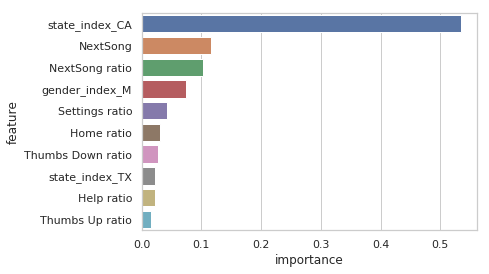

In [123]:
feature_importance_plot(best_model,feature_columns_plot,top_n=10)

From the above plot we see customers who reside in California is the most important feature, followed by the number of songs a customer listened to in the last week (Next Song)

In [124]:
results = best_model.transform(test)

In [125]:
recall, precision, F_score, accuracy = evaluation_metrics(best_model,test,0.5)

In [126]:
print('Area under PR curve: {0:.2f}'.format(eval_roc.evaluate(results)))
print('Accuracy: {0:.2f}'.format(accuracy))
print('Precision: {0:.2f}'.format(precision))
print('Recall: {0:.2f}'.format(recall))
print('F statistic: {0:.2f}'.format(F_score))

Area under PR curve: 0.89
Accuracy: 0.81
Precision: 0.69
Recall: 0.76
F statistic: 0.70


In [127]:
results.crosstab('Churned','prediction').show()

+------------------+---+---+
|Churned_prediction|0.0|1.0|
+------------------+---+---+
|                 1|  7| 22|
|                 0| 50| 10|
+------------------+---+---+



# 5. Results evaluation

We see that by making use of a Gradient Boosting Classifier, we can accurately identify 83% of customers that will churn. This is quite satisfactory